In [1]:
%cd ..

/home/ubuntu/dev/pepper/projects/metric_learning_playground


In [2]:
import os.path as osp
from numbers import Number
from copy import deepcopy

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
# %matplotlib widget

In [4]:
from mmcv import Config
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import load_checkpoint

from mmcls.apis import multi_gpu_test, single_gpu_test
from mmcls.datasets import build_dataset, build_dataloader
from mmcls.models import build_classifier

from src import *
from src.apis import single_gpu_metric_test

In [5]:
# configs

work_dir_name = "lenet_mnist_test"
work_dir_name = "lenet_mnist"
work_dir_name = "lenet_mnist_ce"
model_name = 'lenet'
dataset_name = 'mnist'

ckpt_iter = 6000
ckpt_path = osp.join('work_dirs', work_dir_name, f'iter_{ckpt_iter}.pth')
cfg_fp = osp.join('configs', model_name, f'{model_name}_{dataset_name}.py')
assert osp.exists(cfg_fp)
assert osp.exists(ckpt_path)

# setup variables

cfg = Config.fromfile(cfg_fp)
# print(cfg.pretty_text)

In [6]:
dataset = build_dataset(cfg.data.test, default_args=dict(test_mode=True))

loader_cfg = dict(
    samples_per_gpu=128,
    workers_per_gpu=2,
    num_gpus=1,
    dist=False,
    round_up=True,
)
test_loader_cfg = {
    **loader_cfg,
    "shuffle": False,
    "sampler_cfg": None,
    **cfg.data.get("test_dataloader", {}),
}
data_loader = build_dataloader(dataset, **test_loader_cfg)

/home/ubuntu/.pyenv/versions/3.8.8/lib/python3.8/site-packages/mmcls/datasets/mnist.py:169: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
model = build_classifier(cfg.model)

In [8]:
def get_features(model, checkpoint_path, data_loader, dataset):
    # load checkpoint
    checkpoint = load_checkpoint(model, checkpoint_path, map_location="cpu")
    
    CLASSES = checkpoint["meta"]["CLASSES"]
    print(CLASSES)
    
    # convert model
    model = MMDataParallel(model, device_ids=[0])
    model.CLASSES = CLASSES

    # get predictions and features
    preds, feats = single_gpu_metric_test(
        model, data_loader,
    )
    
    
    eval_results = dataset.evaluate(
        results=preds,
        metric=["accuracy", "f1_score"],
        metric_options=None,
    )
    for k, v in eval_results.items():
        if isinstance(v, np.ndarray):
            v = [round(out, 2) for out in v.tolist()]
        elif isinstance(v, Number):
            v = round(v, 2)
        else:
            raise ValueError(f"Unsupport metric type: {type(v)}")
        print(f"\n{k} : {v}")
        
    return feats

In [9]:
feats = get_features(model, ckpt_path, data_loader, dataset)

load checkpoint from local path: work_dirs/lenet_mnist_ce/iter_6000.pth
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

accuracy_top-1 : 98.93

accuracy_top-5 : 99.9

f1_score : 98.92


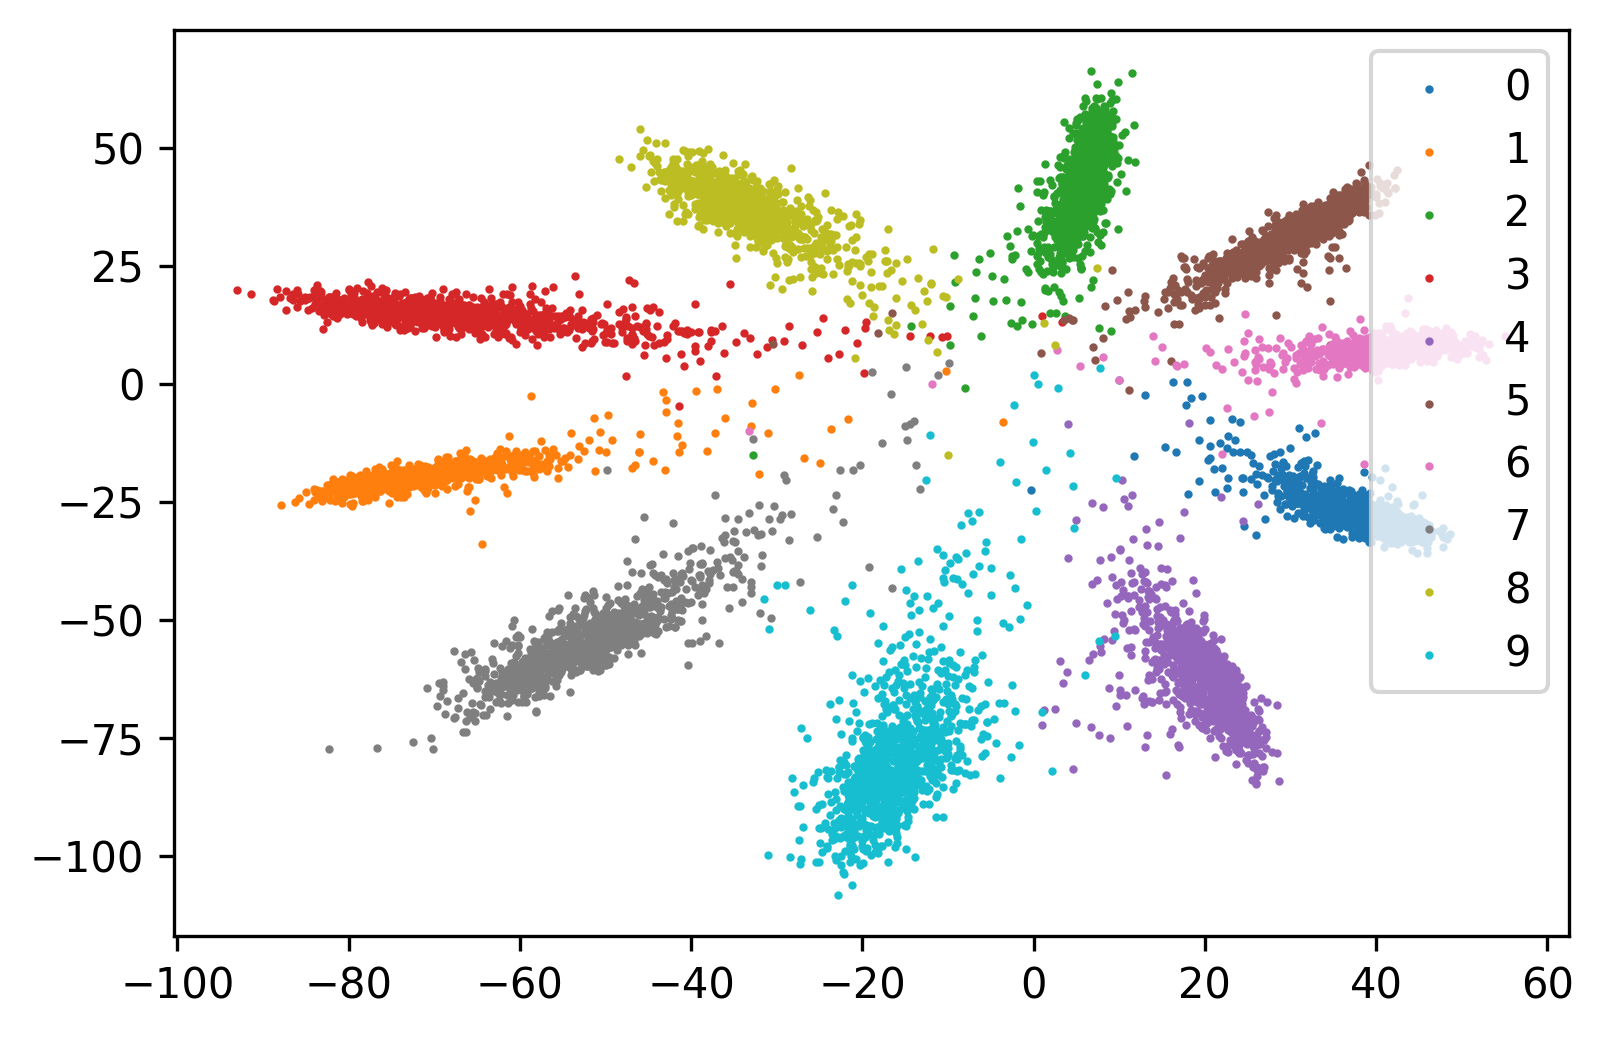

In [11]:
num_classes = 10
labels = np.array(dataset.get_gt_labels())
features = np.array(deepcopy(feats))

plt.gcf().set_dpi(300)

colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9"]
for label_idx in range(num_classes):
    plt.scatter(
        features[labels == label_idx, 0],
        features[labels == label_idx, 1],
        c=colors[label_idx],
        s=1,
    )
plt.legend(
    ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], loc="upper right"
)
plt.savefig('ce_iter_6000.png', dpi = 300)

load checkpoint from local path: work_dirs/lenet_mnist_ce/iter_500.pth
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

accuracy_top-1 : 89.76

accuracy_top-5 : 99.74

f1_score : 89.7
load checkpoint from local path: work_dirs/lenet_mnist_ce/iter_1000.pth
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

accuracy_top-1 : 97.09

accuracy_top-5 : 99.77

f1_score : 97.08
load checkpoint from local path: work_dirs/lenet_mnist_ce/iter_3000.pth
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

accuracy_top-1 : 98.84

accuracy_top-5 : 99.89

f1_score : 98.84
load checkpoint from local path: work_dirs/lenet_mnist_ce/iter_5000.pth
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

accuracy_top-1 : 98.93

accurac

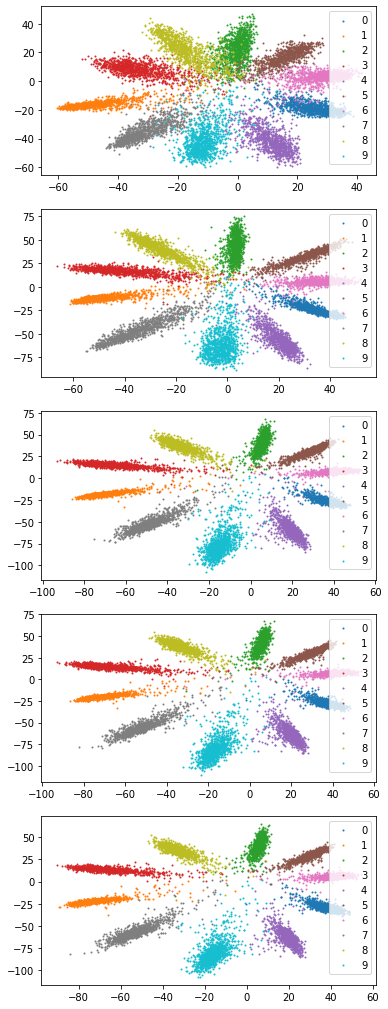

In [12]:
# checkpoints = [2000, 4000, 6000]
checkpoints = [500, 1000, 3000, 5000, 8000]
# plt.gcf().set_dpi(300)

fig, axs = plt.subplots(nrows=len(checkpoints), ncols=1, figsize=(6, 18))

for i, cp in enumerate(checkpoints):
    ckpt_path = osp.join('work_dirs', work_dir_name, f'iter_{cp}.pth')
    assert osp.exists(ckpt_path), ckpt_path
    
    f = get_features(model, ckpt_path, data_loader, dataset)
    features = np.array(deepcopy(f))
    
    colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9"]
    for label_idx in range(num_classes):
        axs[i].scatter(
            features[labels == label_idx, 0],
            features[labels == label_idx, 1],
            c=colors[label_idx],
            s=1,
        )
    axs[i].legend(
        ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], loc="upper right"
    )